# Groeps Opdracht CI
## Joost Vledder, Sadjia Safdari, Simon Kreulen & Jasper van Eck

### Inhoudsopgave <a name='Top'></a>

[Imports](#import)

[Load data](#loaddata)

[Content Based Filtering Algorithm](#contentbased)

[Data Clean Up](#cleanup)

[Basic Data Stats](#basicdata)

[Plots](#plots)

[Cosine Similiraty Content Based](#cossim)

[Query vector](#queryvector)

[SVD](#svd)

[K-Means](#kmeans)

[Cohen Kappa](#cohenkappa)

[Item-Based Collaborative Filtering Algorithm](#itembasedcollab)

[Basic Data Stats for Collabaritive Filtering](#basicdatacollab)

[Implementation](#implementation)

[Deel 1: Mesa](#mesa)

[Deel 2: Calgary](#calgary)


### Imports <a name='import'></a>

[Top](#Top)

In [1]:
import os
import pandas as pd
import numpy as np
np.seterr(divide='raise', over='raise', under='raise', invalid='raise')
import matplotlib.pyplot as plt
from collections import defaultdict
import json
#pip install geopy
from geopy import geocoders
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

### Load data <a name='loaddata'></a>

[Top](#Top)

In [2]:
#rootdir = './yelp/data'
rootdir = './yelp/yelp/data/calgary'

df_business = pd.DataFrame()
df_users = pd.DataFrame()
df_reviews = pd.DataFrame()

count = 0

def load_jsons(data_path, file):
    # function to help load json files, since sometimes they give utf8 encoding errors, sometimes they don't
    file_path = os.path.join(subdir, file)
    lines = []
    with open(file_path) as jsons:
        try:
            lines = [json.loads(json_line) for json_line in jsons]
        except:
            print(file_path)
    return pd.DataFrame(lines)

for subdir, dirs, files in os.walk(rootdir):
    if count == 200: #1078 is the total amount of cities
        break
        
    for file in files:
        if os.path.basename(file) == 'business.json':
            df_business = df_business.append(load_jsons(subdir, file))
        if os.path.basename(file) == 'user.json':
            df_users = df_users.append(load_jsons(subdir, file))
        if os.path.basename(file) == 'review.json':
            df_reviews = df_reviews.append(load_jsons(subdir, file))
    count += 1

df_business = df_business.set_index('business_id')
df_users = df_users.set_index('user_id')
df_reviews = df_reviews.set_index('review_id')

display(df_business.head())
display(df_users.head())
display(df_reviews.head())

,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
business_id,,,,,,,,,,,,,
5JucpCfHZltJh5r1JabjDg,Edgeworxx Studio,20 Douglas Woods Drive Southeast,Calgary,AB,T2Z 1K4,50.943646,-114.001828,3.5,7,1,"{'RestaurantsPriceRange2': '2', 'BusinessParki...","Beauty & Spas, Hair Salons",None
fcXOEZdXYeZqnQ3lGlOXmg,Nucleus Information Service,"1210 8th Street SW, Unit 220",Calgary,AB,T2R 1L3,51.041771,-114.081109,2.0,5,1,"{'BikeParking': 'False', 'ByAppointmentOnly': ...","Local Services, Professional Services, Compute...","{'Monday': '9:0-17:0', 'Tuesday': '9:0-17:0', ..."
e_EMySqP0uwlVZfd8mRaaQ,Pearl Garden,2825 32 Avenue NE,Calgary,AB,T1Y,51.081162,-113.993474,2.0,4,0,"{'BusinessParking': '{'garage': False, 'street...","Chinese, Dim Sum, Restaurants",None
Jff5hTK1ZMLKS06sOSNWdA,Radisson Hotel & Conference Centre Calgary Air...,6620 36 Street NE,Calgary,AB,T3J 4C8,51.111892,-113.980480,3.5,14,1,"{'RestaurantsPriceRange2': '2', 'WiFi': ''free''}","Hotels & Travel, Hotels, Event Planning & Serv...",None
cQ8FKduGfVskvi11NZXsAg,Tomkins Park,880 17 Avenue SW,Calgary,AB,T2T 0A2,51.037994,-114.081367,3.5,3,1,"{'GoodForKids': 'True', 'BusinessParking': '{'...","Parks, Active Life",None


,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
user_id,,,,,,,,,,,,,,,,,,,,,
U4INQZOPSUaj8hMjLlZ3KA,Michael,4308,2008-01-31 02:55:30,22757,10209,16249,"2008,2010,2011,2012,2013,2014,2015","yqumc_CYlWeghZ5vM3Ilyw, mX84lBw8jwS2uQqdgKu_aA...",912,3.88,...,75,43,13,52,442,656,801,801,663,634
GYMIDghm2k7gSTpyKNid1Q,David,764,2009-11-16 05:47:43,2208,983,1193,"2010,2011,2012,2013,2014,2015,2016,2017,2018","Fw7234jE2NpKIxA7OHNQeA, GdawZ1FdT-fvZ0BP1PZV9A...",63,3.55,...,18,32,4,6,120,587,386,386,113,69
l1jYrj9DvTe4t92kGEH3BQ,V,257,2014-05-12 04:49:30,266,104,183,2017,"LDhgLrBDHxTbzLY1O3XkZQ, 5vGVjw4erJX-FsHS60bWpA...",13,3.95,...,0,0,1,0,10,10,17,17,2,13
Vc4QSYKAOf8NXriGXo919Q,Laurel,394,2011-08-29 02:35:29,920,253,386,"2012,2013,2014,2015,2016,2017,2018","LqOAgmXiJoPV4HEsKjfDRQ, oyQqCjdK_u1FiPdyaNov_w...",21,3.88,...,4,1,3,7,44,89,95,95,36,3
zBIFEYvXRQLKQbEpSXipIA,Jay,65,2013-10-10 14:34:21,41,5,14,,"bOAI63GjcSSiKR23nX1Suw, gT-BXzd3N94JRQM0V4r7yA...",3,3.79,...,0,0,0,0,2,5,2,2,1,0


,user_id,business_id,stars,useful,funny,cool,text,date
review_id,,,,,,,,
yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
eed44nI0eZ4BGKtKXsRJhQ,tAcB1ZohRtjozsymvqqHzQ,m7ommfJFalI47UksyX04Iw,1.0,6,2,1,Met a friend for dinner there tonight. The ser...,2014-09-25 08:15:44
UoFxqWXBluvS4Q32spb8Lg,5rWm6uBPeewOiml4pcqp3w,m7ommfJFalI47UksyX04Iw,4.0,0,0,0,Another solid BBQ place in Calgary. This is de...,2014-10-27 04:22:34
ImAnCO3PJXW9fhh7yEazrw,TcByPmEbsEQYJYT7IBKXdg,1-mycIcKFGbvqLE60XrwnQ,3.0,0,0,0,I normally stop here for breakfast when travel...,2014-02-05 19:00:13
g6DFfe58tG9wnPaEnGexfQ,lxHVzV6O2ZU4gm8tA3wVZw,cLx7rt6JTTMU6aO4kBPLnA,5.0,0,0,0,Great food and greatCustomer service.They mess...,2016-09-30 19:39:51


In [3]:
df_business.to_pickle('./business_pickle.pkl')
df_users.to_pickle('./users_pickle.pkl')
df_reviews.to_pickle('./reviews_pickle.pkl')

In [4]:
df_business = pd.read_pickle('./business_pickle.pkl')
df_users = pd.read_pickle('./users_pickle.pkl')
df_reviews = pd.read_pickle('./reviews_pickle.pkl')

### Clean up Data For Content Based <a name='cleanup'></a>

[Top](#Top)

In [5]:
cat_dict = defaultdict(lambda: defaultdict(int))

# Drop na categories
df_business = df_business[df_business['categories'].notna()]

# Normalize long, lat, stars & review_count
#x = cos(lat) * cos(lon)
#y = cos(lat) * sin(lon)
df_business['stars'] = (df_business['stars']-df_business['stars'].min()) / (df_business['stars'].max()-df_business['stars'].min())
df_business['review_count'] = (df_business['review_count']-df_business['review_count'].min()) / (df_business['review_count'].max()-df_business['review_count'].min())
#df_business['x_axis'] = np.cos(df_business['latitude']) * np.cos(df_business['longitude'])
#df_business['y_axis'] = np.cos(df_business['latitude']) * np.sin(df_business['longitude'])

# Dataframe of categories one hot encoded per business_id
df_tmp = df_business['categories'].str.split(pat=', ',expand=True)

# Create dict of categories
for index, row in df_tmp.iterrows():
    for _,elem in row.items():
        if elem and elem not in cat_dict[index]:
            cat_dict[index][elem] += 1  

In [6]:
# Create DF from dict
df_cats = pd.DataFrame.from_dict(cat_dict, orient='index')

#Drop NaN column
df_cats = df_cats.drop(columns='NaN',errors='ignore')

# Fillna with 0
df_cats = df_cats.fillna(0)

# Join back into business
df_business = df_business.join(df_cats,on='business_id')

# Drop cols
df_business = df_business.drop(columns=['address','state','postal_code','attributes','categories','hours'],errors='ignore')

# Remove elite & friends columns because of non use
df_users = df_users.drop(columns=['elite','friends'],axis=1,errors='ignore')

In [7]:
df_business.to_pickle('./business_pickle.pkl')
df_users.to_pickle('./users_pickle.pkl')
df_reviews.to_pickle('./reviews_pickle.pkl')

In [8]:
df_business = pd.read_pickle('./business_pickle.pkl')
df_users = pd.read_pickle('./users_pickle.pkl')
df_reviews = pd.read_pickle('./reviews_pickle.pkl')

### Basic Data Stats for Content Based <a name='basicdata'></a>

[Top](#Top)

In [9]:
# Some information about the category amounts per business

# series of amount of categories per business
cats_business = df_cats.sum(axis=1).sort_values(ascending=False)
display(cats_business)

avg_cats_bus = cats_business.mean()
max_cats_bus = cats_business.max()
min_cats_bus = cats_business.min()

print('Average amount of categories for businesses: ', avg_cats_bus)
print('Minimum amount of categories for businesses: ', min_cats_bus)
print('Maximum amount of categories for businesses: ', max_cats_bus)

# series of amount of businesses with the index amount of categories
cat_bus_distribution = cats_business.value_counts()
display(cat_bus_distribution)

2_hS4fzhosE-tmEG2M-rXA    20.0
BrJ6FUqk4kdS3Myamimuyw    18.0
f-PdDd8rrMtC3Ngmkfac9w    18.0
eSfElFSh7PPPIDX-U1EYug    17.0
7PwfygMSJcN2ZqcJRIWX9Q    17.0
                          ... 
lep3t7Gbk67_lkdNSSlL8g     1.0
J9RZsfvUE6zPAv8AhxtCpg     1.0
g83GKlDyoGY3ubjuJKxgdA     1.0
I3MOR01qCD5-yZfW0Brm7Q     1.0
J0fqSOCq6FfrVN3LxIATYw     1.0
Length: 7725, dtype: float64

Average amount of categories for businesses:  3.929061488673139
Minimum amount of categories for businesses:  1.0
Maximum amount of categories for businesses:  20.0


2.0     2234
3.0     1571
4.0     1364
5.0     1032
6.0      643
7.0      378
8.0      200
9.0      124
1.0       66
10.0      57
11.0      26
12.0      13
13.0       5
14.0       4
18.0       2
17.0       2
15.0       2
16.0       1
20.0       1
dtype: int64

In [10]:
# series of number of businesses with index as category
cats_presences = df_cats.sum(axis=0).sort_values(ascending=False)
display(cats_presences)

avg_cats = cats_presences.mean()
max_cats = cats_presences.max()
min_cats = cats_presences.min()

print('Average amount of presence of a category: ', avg_cats)
print('Minimum amount of presence of a category: ', min_cats)
print('Maximum amount of presences of a category: ', max_cats)

Restaurants             2912.0
Food                    1508.0
Shopping                1475.0
Beauty & Spas            801.0
Nightlife                652.0
                         ...  
Piano Bars                 1.0
Makerspaces                1.0
Apartment Agents           1.0
Debt Relief Services       1.0
Registry Office            1.0
Length: 780, dtype: float64

Average amount of presence of a category:  38.91282051282051
Minimum amount of presence of a category:  1.0
Maximum amount of presences of a category:  2912.0


### Plots <a name='plots'></a>

[Top](#Top)

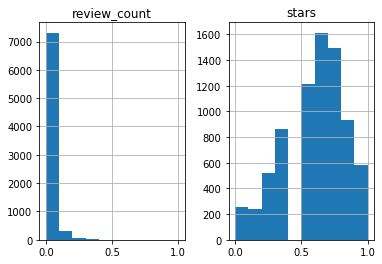

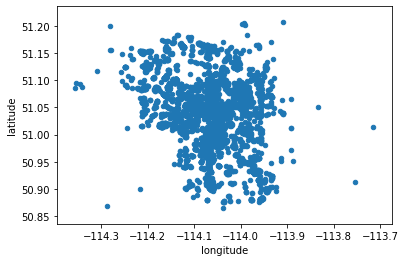

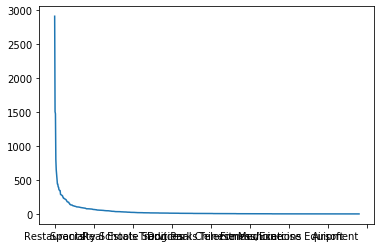

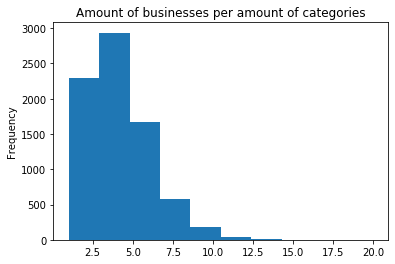

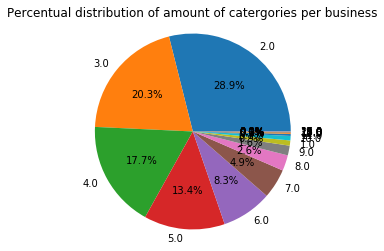

In [11]:
hist_bus = df_business.hist(column=['stars','review_count'])
#df_business.plot(x='x_axis',y='y_axis',kind='scatter')
df_business.plot(x='longitude',y='latitude',kind='scatter')
plt.show()
cats_presences.plot()
plt.show()

cats_business.plot(kind='hist',subplots=False,sharex=False,sharey=False,title='Amount of businesses per amount of categories')
plt.show()

total_cats = sum(cat_bus_distribution.values)
percentages = [(value/total_cats) * 100 for value in cat_bus_distribution.values]

fig1, circle = plt.subplots()
circle.pie(percentages, labels=cat_bus_distribution.index, autopct='%1.1f%%')
circle.axis('equal')
plt.title('Percentual distribution of amount of catergories per business')
plt.show()

In [12]:
df_business = pd.read_pickle('./business_pickle.pkl')
df_cats = pd.read_pickle('./cats_pickle.pkl')
df_users = pd.read_pickle('./users_pickle.pkl')
df_reviews = pd.read_pickle('./reviews_pickle.pkl')

### Cosine Similarity <a name='cossim'></a>

[Top](#Top)

In [13]:
# Input vectors are series, convert to np array
def cosineSim(vector, docVector):
    vector = vector.to_numpy()
    docVector = docVector.to_numpy()
    
    # Get lengths of vectors
    sim = (np.sqrt(sum(vector**2))*np.sqrt(sum(docVector**2)))
    
    # Ensure no division by 0
    if sim == 0.:
        return np.nan
    
    # Calculate cosine sim
    return vector.dot(docVector)/sim

In [14]:
def rankedBusinessList(df_business, queryVector):
    df_bus_features = df_business.copy().drop(columns=['name','city','stars','review_count','is_open','Score Cos'],errors='ignore')
    scoreList = np.zeros(len(df_business))
    for i in range(len(df_bus_features)):
        scoreList[i] = cosineSim(queryVector, df_bus_features.iloc[i])
    
    df_business['Score Cos'] = scoreList
    return df_business.sort_values(by=['Score Cos','stars'],ascending=False)

### Create Query Vector <a name='queryvector'></a>

[Top](#Top)

This first cell get the longitude and latitude of a given city and state, and normalizes both values.

In [15]:
display(df_business['city'].value_counts().sort_values(ascending=False))

Calgary    7723
calgary       1
CALGARY       1
Name: city, dtype: int64

In [16]:
loc_string = 'Calgary AB'
gn = Nominatim(user_agent='WalterGKurtz')
location = gn.geocode(loc_string)
queryVector = pd.Series(data=0.,index=df_business.columns)
queryVector.at['latitude'] = location.latitude
queryVector.at['longitude'] = location.longitude
#x = cos(lat) * cos(lon)
#y = cos(lat) * sin(lon)
#queryVector.at['x_axis'] = np.cos(location.latitude) * np.cos(location.longitude)
#queryVector.at['y_axis'] = np.cos(location.latitude) * np.sin(location.longitude)


The second cell inputs the preferences of the user.

In [17]:
# Preferences
queryVector = queryVector.drop(labels=['name','city','stars','review_count','is_open','Score Cos'],errors='ignore')
queryVector.at['Dry Cleaning & Laundry'] = 1.
queryVector.at['Sewing & Alterations'] = 1.
queryVector.at['Bridal'] = 1.
queryVector.at['Convenience Stores'] = 1.
queryVector.at['Laundry Services'] = 1.
queryVector.at['Dry Cleaning'] = 1.
queryVector.at['Laundromat'] = 1.
#queryVector.at['Day Spas'] = 1.
display(queryVector)
#queryVector.to_csv('test.csv', header=False)

latitude             51.053423
longitude          -114.062589
Beauty & Spas         0.000000
Hair Salons           0.000000
Local Services        0.000000
                       ...    
Pretzels              0.000000
Argentine             0.000000
Wildlife Control      0.000000
Basque                0.000000
Registry Office       0.000000
Length: 782, dtype: float64

In [18]:
display(rankedBusinessList(df_business,queryVector).head(20))

,name,city,latitude,longitude,stars,review_count,is_open,Beauty & Spas,Hair Salons,Local Services,...,Austrian,Resorts,Singaporean,Bangladeshi,Pretzels,Argentine,Wildlife Control,Basque,Registry Office,Score Cos
business_id,,,,,,,,,,,,,,,,,,,,,
uLJt8RwUTz4DAFYljSFozA,Kaycie's Alterations & Dry Cleaning,Calgary,51.075042,-114.167608,1.000,0.002457,1,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999872
63Lr6sKX-x0EhuxyjJ_5AQ,Lee's Drycleaning & Alterations,Calgary,51.089156,-114.117892,0.625,0.002457,1,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999872
f3IXikOmUu4dZVpsi57bgw,Gangnam Style Alterations & Drycleaning,Calgary,51.045277,-114.065716,0.875,0.019656,1,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999872
MkDRoxUKBEmmuPVjZv-RTQ,Edmonton Trail Laundromat & Dry Cleaning,Calgary,51.058534,-114.054661,0.500,0.000000,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999872
lful_Rz11iGDuwxr6m0Qlg,Oh Henry's Laundromat & Drycleaners,Calgary,51.036840,-114.072252,0.875,0.002457,1,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999872
Eu0nFK-u2hIFv8QTlDW2cg,Kingsland Drycleaning & Alteration,Calgary,50.985170,-114.082319,0.750,0.000000,1,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999872
b0hP7meEh7i9fEc34-stzQ,White Rose Cleaners,Calgary,51.116418,-114.204952,0.000,0.000000,1,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999840
Vt4RPq1nkUI5GI4G8JXyQw,Richard's Dry Cleaning,Calgary,51.129998,-114.200856,0.000,0.000000,1,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999840
28KycWn1WRLdOXs4VMjaTA,Martinizing By Stephen Cleaners,Calgary,51.128598,-114.198810,0.625,0.000000,1,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999840


### SVD <a name='svd'></a>

[Top](#Top)

In [19]:
stars = df_business['stars'].values
cities = df_business['city'].values
names = df_business['name'].values
bus_ids = df_business.index
df_tmp_svd = df_business.copy().drop(columns=['name','city', 'stars','review_count','is_open', 'Score Cos'],errors='ignore').to_numpy()

In [20]:
# This code can be used to find the optimal amount of dimension by the SVD

# trunc_svd = TruncatedSVD(n_components=len(df_tmp_svd[0])-1).fit(df_tmp_svd)
# reduced_x = trunc_svd.transform(df_tmp_svd)
# singles = trunc_svd.singular_values_

# eigvals = singles**2 / np.sum(singles**2)
# fig = plt.figure(figsize=(8,5))
# sing_vals = np.arange(len(df_tmp_svd[0])-1) + 1
# plt.plot(sing_vals[2:200], eigvals[2:200], 'ro-', linewidth=2)
# plt.title('Scree Plot')
# plt.xlabel('Component number')
# plt.ylabel('Eigenvalue')
# plt.show()

In [21]:
optimal_dims = 25
trunc_svd = TruncatedSVD(n_components=optimal_dims).fit(df_tmp_svd)
reduced_x = trunc_svd.transform(df_tmp_svd)

In [22]:
queryVectorReduced = trunc_svd.transform(np.array([queryVector]))

df_reduced_x = pd.DataFrame(data=reduced_x, index=bus_ids)
df_reduced_x.insert(0, 'stars', stars)
df_reduced_x.insert(0, 'city', cities)
df_reduced_x.insert(0, 'name', names)
df_queryVectorReduced = pd.Series(data=queryVectorReduced[0])
display(rankedBusinessList(df_reduced_x,df_queryVectorReduced).head(20))

,name,city,stars,0,1,2,3,4,5,6,...,16,17,18,19,20,21,22,23,24,Score Cos
business_id,,,,,,,,,,,,,,,,,,,,,
tCi8U5QpzcfJAGrsYp7_hA,New Wave Media,Calgary,0.625,124.975674,-0.277460,-0.028928,0.174144,-0.000471,-0.221820,-0.212364,...,-0.010099,-0.046180,-0.006810,-0.001851,-0.066133,-0.079991,-0.004610,0.076488,0.000007,0.999998
cZRNvTq0bmvC9WViv_XhIg,Calgary Signs & Banners,Calgary,0.000,124.929821,-0.274869,-0.029150,0.174334,-0.000185,-0.218345,-0.203801,...,-0.011251,-0.050365,-0.003425,-0.003013,-0.069096,-0.082483,-0.005059,0.079331,0.006677,0.999997
nex50Umab9MlR7a7nqMRCw,Stemp & Company,Calgary,0.625,124.984988,-0.276141,-0.028773,0.180087,0.000406,-0.224808,-0.207426,...,-0.012787,-0.057406,0.003301,-0.006707,-0.080536,-0.096203,-0.007437,0.091529,0.011377,0.999997
OVCGvGRCu9JNFsPHNMjyrA,Kahane Law Office Barristers & Solicitors,Calgary,0.625,124.941958,-0.275941,-0.028658,0.179525,0.000585,-0.223397,-0.207316,...,-0.012565,-0.057153,0.003507,-0.006360,-0.079808,-0.095390,-0.007001,0.090681,0.011580,0.999997
4Mjx19JQES_hFG1UaWDrYQ,Masuch Albert,Calgary,0.000,124.868275,-0.275667,-0.028608,0.179313,0.000606,-0.222948,-0.206629,...,-0.012579,-0.057308,0.004037,-0.006300,-0.079628,-0.095231,-0.006899,0.090261,0.011533,0.999997
X5kFyoknoOgaiebbHrVSuA,Soby Boyden Lenz,Calgary,0.625,124.984364,-0.274972,-0.028552,0.178739,0.000414,-0.221768,-0.204091,...,-0.012598,-0.056839,0.003433,-0.006389,-0.078186,-0.093675,-0.006832,0.087406,0.011203,0.999997
AECYvrXtr65XX4kE16SxXA,Divorce EZ,Calgary,0.000,125.087677,-0.275202,-0.028565,0.178860,0.000444,-0.221851,-0.204176,...,-0.012583,-0.056882,0.003459,-0.006342,-0.078207,-0.093702,-0.006763,0.087465,0.011244,0.999997
TzQJ1j0yqWlDhLE3HZC8uw,Southland Registrations,Calgary,0.625,124.942788,-0.280849,-0.029969,0.185059,0.001195,-0.237496,-0.216741,...,-0.018060,-0.072663,0.001907,0.014851,-0.099108,-0.111657,-0.001169,0.110751,0.019790,0.999997
aeBxmhNVO_B-q3Crw6CV1w,Gottlieb & Tillier Law Office,Calgary,0.000,124.992853,-0.274986,-0.028662,0.179054,0.000192,-0.222667,-0.205160,...,-0.012841,-0.056997,0.004281,-0.006656,-0.078392,-0.093965,-0.007412,0.087388,0.010969,0.999997


### K-means <a name='kmeans'></a>

[Top](#Top)

In [23]:
# # This block of code was used to find the optimal K, it takes very long to run, so that's why it is commented now.

# from yellowbrick.cluster import KElbowVisualizer

# df_bus_kmeans = df_reduced_x.copy().drop(columns=['name','city','stars','Score Cos'],errors='ignore').to_numpy()

# # choose k

# model = KMeans(random_state=0)
# visualizer = KElbowVisualizer(model, k=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
# visualizer.fit(df_bus_kmeans)        # Fit the data to the visualizer
# visualizer.show() 

In [24]:
df_bus_kmeans = df_reduced_x.copy().drop(columns=['name','city','stars','Score Cos'],errors='ignore').to_numpy()
kmeans = KMeans(n_clusters=300,random_state=0).fit(df_bus_kmeans)

In [25]:
# Predict query vector
labels = np.array(kmeans.predict(df_bus_kmeans))
prediction = kmeans.predict([df_queryVectorReduced.to_numpy()])

matches = [y[0] for y,val in np.ndenumerate(labels) if val == prediction]

df_matched = df_business.iloc[matches]

display(df_matched.sort_values(by=['stars'],ascending=False).head(20))

,name,city,latitude,longitude,stars,review_count,is_open,Beauty & Spas,Hair Salons,Local Services,...,Austrian,Resorts,Singaporean,Bangladeshi,Pretzels,Argentine,Wildlife Control,Basque,Registry Office,Score Cos
business_id,,,,,,,,,,,,,,,,,,,,,
s0VoTKlqNZVV78d0PGMbpQ,Censea Business Solutions,Calgary,51.068199,-114.015722,1.000,0.000000,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999616
sLffujv_9tIzVy8alZF3xA,Aportto Translation,Calgary,51.048917,-114.070641,1.000,0.000000,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999712
RKaM0OZ3iGc5WZJJfsXt6A,David Aplin Group,Calgary,51.046316,-114.067394,0.875,0.000000,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999712
40TLFWHTYc94YaTo67wgdg,Forward Professional Group,Calgary,51.005469,-114.130157,0.750,0.004914,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999584
tCi8U5QpzcfJAGrsYp7_hA,New Wave Media,Calgary,51.043006,-114.077989,0.625,0.000000,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999616
nex50Umab9MlR7a7nqMRCw,Stemp & Company,Calgary,51.046227,-114.086753,0.625,0.000000,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999488
_iY9VxawjB2BQmD8kiWugg,Angus One Professional Recruitment and Templine,Calgary,51.045627,-114.070347,0.625,0.000000,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999712
TzQJ1j0yqWlDhLE3HZC8uw,Southland Registrations,Calgary,50.967691,-114.075599,0.625,0.017199,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999648
OVCGvGRCu9JNFsPHNMjyrA,Kahane Law Office Barristers & Solicitors,Calgary,50.987616,-114.065838,0.625,0.022113,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999616


### Cohen's Kappa <a name='cohenkappa'></a>

[Top](#Top)

In [26]:
# Dataformat
# 1 | 0
# 1 | 1
# 0 | 1

def PE(data):
    '''On input data, return the P(E) (expected agreement).'''
    relevant = 0
    nonrelevant = 0
    # Iterate over the data
    for i in data:
        for j in i:
            
            # Top up the relevant documents by one if 1 is encountered
            if j == 1:
                relevant += 1
            # Top up the nonrelevant documents by one if 0 is encountered
            if j == 0:
                nonrelevant += 1

    # Calculates the total of inspected documents for the judges combined
    total = len(data)*2

    # Calculates the pooled marginals
    rel = relevant/total
    nonrel = nonrelevant/total
    
    # Calculates the P(E)
    P_E = nonrel**2 + rel**2    
    return P_E 


def cohen_kappa(data, P_E):
    agree = 0
    for i in data:
        temp = None
        for j in i:
            if temp == j:
                agree += 1
            temp = j
    P_A = agree / len(data)
    if P_E == 1:
        kappa = 1
    else:
        kappa = (P_A - P_E)/(1 - P_E)   
    return kappa

In [27]:
data = [[1,1],[1,1],[1,1],[1,1],[0,0],[0,1],[1,1],[1,1],[1,1],[1,0],[1,1],[1,1],[1,1],[1,1],[0,1],[1,1],[1,1],[1,1],[1,1],[1,0]]
P_E = PE(data)
print(cohen_kappa(data,P_E))

0.21568627450980446


In [28]:
def AveragePrecision(ranked_list_of_results, list_of_relevant_objects):
    total = len(list_of_relevant_objects)
    if total == 0:
        return 0
    sumPk = 0
    rank = 0
    relevant = 0
    for result in ranked_list_of_results:
        rank += 1
        if result in list_of_relevant_objects:
            relevant += 1
            sumPk += relevant/rank
            
    aprecision = sumPk/total
    return aprecision

In [29]:
ranked_result_list = list(range(20))
relevant_objects_cos = [0,2,4,5,6,9,10,11,12,13,14,15,16,17,18]
relevant_objects_kmeans = [0,1,2,3,6,7,8,10,11,12,13,15,16,17,18]
print('Average Precision of cosine sim: ', AveragePrecision(ranked_result_list,relevant_objects_cos))
print('Average Precision of K-Means: ', AveragePrecision(ranked_result_list,relevant_objects_kmeans))

Average Precision of cosine sim:  0.7181688956611558
Average Precision of K-Means:  0.8237492412415014


## Item-Based Collaborative Filtering Algorithm <a name='itembasedcollab'></a>

[Top](#Top)


### Basic Data Stats for Collaborative Based <a name='basicdatacollab'></a>

[Top](#Top)


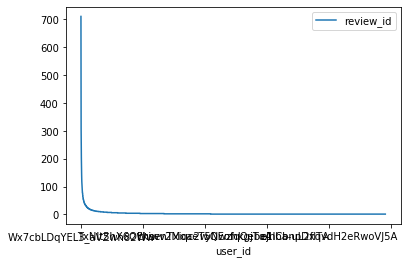

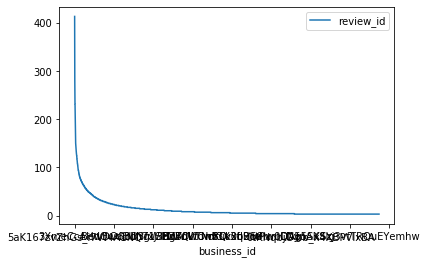

In [30]:
# reset index
df_reviews = df_reviews.reset_index()

# count reviews per user and reviews per business
reviews_per_user = df_reviews.groupby("user_id")["review_id"].count().sort_values(ascending=False).to_frame()
reviews_per_business = df_reviews.groupby("business_id")["review_id"].count().sort_values(ascending=False).to_frame()


# plot both review counts
user_plot = reviews_per_user.plot()
business_plot = reviews_per_business.plot()

user_id
RtGqdDBvvBCjcu5dUqwfzA    12390
hWDybu_KvYLSdEFzGrniTw    10022
Xwnf20FKuikiHcSpcEbpKQ     6738
CxDOIDnH8gp9KXzpBHJYXw     6314
HFECrzYDpgbS5EmTBtj2zQ     5398
                          ...  
liFi2B1da4I2Qx21iSpqAg        4
xlxei12UACMFJc-jbkAnAw        3
0vhASTZ0Bf8CgJQcKB3o9w        2
ImgHIVD8ZZAjF0FXY-mdyQ        1
rTxdGnDkQZo3KmwMoY_OeA        0
Name: review_count, Length: 669, dtype: int64

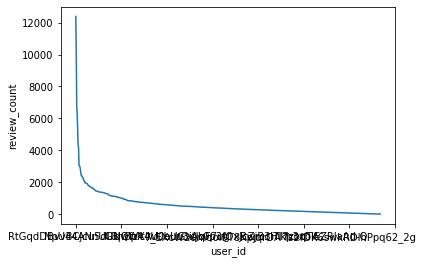

In [31]:
"""""
userplot --> the distribution of the reviews over the users (long-tail): considering the fact that there are more
reviews on business than users (one user can rate more than 1 business), it is probably better to choose
item-based CF than user-based CF. 

"""""
users_series = df_users['review_count'].sort_values(ascending=False).drop_duplicates(keep='first')

display(users_series)
userplot = users_series.plot()

userplot.set(xlabel='user_id', ylabel='review_count')
plt.show()

### Implementation <a name='implementation'></a>


[Top](#Top)

### Deel 1: Mesa <a name='mesa'></a>

[Top](#Top)

In [32]:
reviews = df_reviews[:500]
reviews

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
1,eed44nI0eZ4BGKtKXsRJhQ,tAcB1ZohRtjozsymvqqHzQ,m7ommfJFalI47UksyX04Iw,1.0,6,2,1,Met a friend for dinner there tonight. The ser...,2014-09-25 08:15:44
2,UoFxqWXBluvS4Q32spb8Lg,5rWm6uBPeewOiml4pcqp3w,m7ommfJFalI47UksyX04Iw,4.0,0,0,0,Another solid BBQ place in Calgary. This is de...,2014-10-27 04:22:34
3,ImAnCO3PJXW9fhh7yEazrw,TcByPmEbsEQYJYT7IBKXdg,1-mycIcKFGbvqLE60XrwnQ,3.0,0,0,0,I normally stop here for breakfast when travel...,2014-02-05 19:00:13
4,g6DFfe58tG9wnPaEnGexfQ,lxHVzV6O2ZU4gm8tA3wVZw,cLx7rt6JTTMU6aO4kBPLnA,5.0,0,0,0,Great food and greatCustomer service.They mess...,2016-09-30 19:39:51
...,...,...,...,...,...,...,...,...,...
495,o4x5PellxGqTVXWCgdrlJQ,xETBGJBMetMwT29fEtD1ug,JmEdImxiiEq2NfPVP5dT-w,1.0,0,0,0,The cheaper version of Famoso pizza.....and I'...,2016-07-04 16:39:17
496,atFggKzChMVrYGCSk4LSyQ,hVg-oVVHUG3btMdnIDtVTg,_kSNwOubRygbLPFWRMvhqA,4.0,0,0,1,"Definitely on the pricier side, but the food i...",2016-05-20 16:00:18
497,ccHHFN-jwHLTNXhF8mlsZg,frFgM9DQbewbeMznT8FofA,JHorcZdXHhJZTOh4N6NDkg,4.0,2,0,0,"I play poker...and by ""poker"", I mean no-limit...",2011-10-30 04:46:33
498,wSu1Fkatc5aokNBs87oaDw,hFBr2osNZXYP00c_YhygRw,aGWcIRCcbq_EohFmB51lVQ,4.0,0,0,0,Great off leash park full fence and gated,2016-01-30 21:16:21


In [33]:
def pivot_ratings(ratings):
    pivottable = ratings.pivot_table(index="business_id", columns="user_id", values="stars").fillna(0)
    return pivottable

utility_matrix = pivot_ratings(reviews)
#display(utility_matrix.loc['mRUVMJkUGxrByzMQ2MuOpA'][utility_matrix.loc['mRUVMJkUGxrByzMQ2MuOpA'].notna()])
display(utility_matrix)

user_id,-B8S5kAQoz9qUmWaQ1F_dg,-InhDRRVG7wrwsgAUvN4Qw,-McMa2fZboJAno4DdiPBEw,-MtMCXIgupfxAml5embtBw,-YGTX1vEWUOolMNbdAFUUQ,-eyD9AcOndfdUexRDjWmrw,-gzH91WI8-RphjXAfuR8xQ,-u8y3efQyO4gNZ2zjrRiQA,-yqPcuxB7rlBVKjEaZLn5Q,-zSnLWbNZtNoKnUpothzrg,...,ybWp7BT6L3SwEfLg8NM77Q,ynkHBsaBm4g-U4J_mLNdPw,yq08abQ-4RyNaP8SOhapYQ,z6VZrWNIAVw8Nv1w065tLg,zBIFEYvXRQLKQbEpSXipIA,zIl0SdTw-WyFMe22mKhxjQ,zN9eefIbeqiYAb5KTvUwmg,zlF-gyv5_lcaUxvi53TZ0A,zqoSKGlr6DRmPFFNCyYnog,zsgcmHVGX492QXIAKLMviQ
business_id,,,,,,,,,,,,,,,,,,,,,
-3n__pVgU99k4jaSANVFgw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-CONW9LHiX3Hg4C3exGdPA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-Rc3kdOKC9inz_Cb2o0Byw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-cX1ajn5QYMDy0kkqR4JSg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0VQqe49KJYsBT0klrkCzhg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yvtIchBAhau_b7CQ2DyycA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yyO_va12srp7Mo8pXm7olA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
z9behwB3eDTiPd3mrtCH1A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
def cosine_distance(matrix, id1, id2):
    selected_features = matrix.loc[id1].notna() & matrix.loc[id2].notna()
    
    # if no matching features, return 'not a number' (NaN)
    if not selected_features.any():
        return np.nan
    
    # get the features from the matrix
    features1 = matrix.loc[id1][selected_features]
    features2 = matrix.loc[id2][selected_features]

    #if sum(features1)==0. or sum(features2)==0.:
        #return 1.
    
    if id1 == id2:
        return 1.
    
    sim = (np.sqrt(sum(features1**2))*np.sqrt(sum(features2**2)))
    
    if sim == 0.:
        return np.nan
    
    return sum(features1*features2)/sim
    
def create_similarity_matrix_cosine(matrix):
    similarity_matrix = pd.DataFrame(0, index=matrix.index, columns=matrix.index, dtype=float)
    # Iter of rows & columns, cause I couldnt get apply/-map to work
    for index, row in similarity_matrix.iteritems():
        for i in row.index:
            similarity_matrix.at[index,i] = cosine_distance(matrix,index,i)
    
    return similarity_matrix

#display(create_similarity_matrix_euclid(matrix))
    
#similarity = create_similarity_matrix_cosine(utility_matrix)
#display(similarity)

In [35]:
def mean_center_columns(matrix):
     return matrix.apply(lambda x: x - x.mean())

# centered_utility_matrix = mean_center_columns(utility_matrix)
# display(centered_utility_matrix)

# similarity = create_similarity_matrix_cosine(centered_utility_matrix)
# display(similarity)

#    mean_centered = matrix.copy()
#    for col in list(matrix.columns):
#        mean_centered[col] -= matrix[col].mean()
#        
#    return mean_centered


centered_utility_matrix = mean_center_columns(utility_matrix)
display(centered_utility_matrix)


similarity = create_similarity_matrix_cosine(centered_utility_matrix)
display(similarity)

user_id,-B8S5kAQoz9qUmWaQ1F_dg,-InhDRRVG7wrwsgAUvN4Qw,-McMa2fZboJAno4DdiPBEw,-MtMCXIgupfxAml5embtBw,-YGTX1vEWUOolMNbdAFUUQ,-eyD9AcOndfdUexRDjWmrw,-gzH91WI8-RphjXAfuR8xQ,-u8y3efQyO4gNZ2zjrRiQA,-yqPcuxB7rlBVKjEaZLn5Q,-zSnLWbNZtNoKnUpothzrg,...,ybWp7BT6L3SwEfLg8NM77Q,ynkHBsaBm4g-U4J_mLNdPw,yq08abQ-4RyNaP8SOhapYQ,z6VZrWNIAVw8Nv1w065tLg,zBIFEYvXRQLKQbEpSXipIA,zIl0SdTw-WyFMe22mKhxjQ,zN9eefIbeqiYAb5KTvUwmg,zlF-gyv5_lcaUxvi53TZ0A,zqoSKGlr6DRmPFFNCyYnog,zsgcmHVGX492QXIAKLMviQ
business_id,,,,,,,,,,,,,,,,,,,,,
-3n__pVgU99k4jaSANVFgw,-0.018382,-0.110294,-0.018382,-0.014706,-0.018382,-0.014706,-0.011029,-0.018382,-0.003676,-0.007353,...,-0.014706,-0.014706,-0.007353,-0.014706,-0.011029,-0.007353,-0.033088,-0.014706,-0.018382,-0.014706
-CONW9LHiX3Hg4C3exGdPA,-0.018382,-0.110294,-0.018382,-0.014706,-0.018382,-0.014706,-0.011029,-0.018382,-0.003676,-0.007353,...,-0.014706,-0.014706,-0.007353,-0.014706,-0.011029,-0.007353,-0.033088,-0.014706,-0.018382,-0.014706
-Rc3kdOKC9inz_Cb2o0Byw,-0.018382,-0.110294,-0.018382,-0.014706,-0.018382,-0.014706,-0.011029,-0.018382,-0.003676,-0.007353,...,-0.014706,-0.014706,-0.007353,-0.014706,-0.011029,-0.007353,-0.033088,-0.014706,-0.018382,-0.014706
-cX1ajn5QYMDy0kkqR4JSg,-0.018382,-0.110294,-0.018382,-0.014706,-0.018382,-0.014706,-0.011029,-0.018382,-0.003676,-0.007353,...,-0.014706,-0.014706,-0.007353,-0.014706,-0.011029,-0.007353,-0.033088,-0.014706,-0.018382,-0.014706
0VQqe49KJYsBT0klrkCzhg,-0.018382,-0.110294,-0.018382,-0.014706,-0.018382,-0.014706,-0.011029,-0.018382,-0.003676,-0.007353,...,-0.014706,-0.014706,-0.007353,-0.014706,-0.011029,-0.007353,-0.033088,-0.014706,-0.018382,-0.014706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yvtIchBAhau_b7CQ2DyycA,-0.018382,-0.110294,-0.018382,-0.014706,-0.018382,-0.014706,-0.011029,-0.018382,-0.003676,-0.007353,...,-0.014706,-0.014706,-0.007353,-0.014706,-0.011029,-0.007353,-0.033088,-0.014706,-0.018382,-0.014706
yyO_va12srp7Mo8pXm7olA,-0.018382,-0.110294,-0.018382,-0.014706,-0.018382,-0.014706,-0.011029,-0.018382,-0.003676,-0.007353,...,-0.014706,-0.014706,-0.007353,-0.014706,-0.011029,-0.007353,-0.033088,-0.014706,-0.018382,-0.014706
z9behwB3eDTiPd3mrtCH1A,-0.018382,-0.110294,-0.018382,-0.014706,-0.018382,-0.014706,-0.011029,-0.018382,-0.003676,-0.007353,...,-0.014706,-0.014706,-0.007353,-0.014706,-0.011029,-0.007353,-0.033088,-0.014706,-0.018382,-0.014706


business_id,-3n__pVgU99k4jaSANVFgw,-CONW9LHiX3Hg4C3exGdPA,-Rc3kdOKC9inz_Cb2o0Byw,-cX1ajn5QYMDy0kkqR4JSg,0VQqe49KJYsBT0klrkCzhg,1-mycIcKFGbvqLE60XrwnQ,13MFlacAt5zyLyRGCtDS3w,1QywlTGujVzVXaqWDdUbkQ,1VVxaJWiUq_ETAAN89a2Tg,1bhltGy3AhUDay3AZ_k2RQ,...,xztZMoSCWsuqGwv-7PNEMg,y2muNHhkNNke2q8dd5GROg,yCH_OCKFw4jYdnQKyfoMFQ,yPzcnXlZ4VfCqPrXgwbS9A,ygLcYFoKRP3PcUXcDKnz0w,yvtIchBAhau_b7CQ2DyycA,yyO_va12srp7Mo8pXm7olA,z9behwB3eDTiPd3mrtCH1A,zUct0miShgOPuNad8BEJjw,zs3V4WqtYVMhIoycEeirRA
business_id,,,,,,,,,,,,,,,,,,,,,
-3n__pVgU99k4jaSANVFgw,1.000000,0.008364,-0.020465,-0.001663,-0.004837,-0.003745,0.002355,-0.000934,0.001151,0.002426,...,-0.005374,-0.000934,0.000488,-0.006001,-0.002460,0.002355,0.002355,0.002355,-0.000221,-0.007608
-CONW9LHiX3Hg4C3exGdPA,0.008364,1.000000,-0.058043,0.006939,-0.008313,-0.005113,0.027177,0.008364,0.019896,0.036882,...,-0.006732,0.008364,0.016075,-0.014686,0.006072,0.027177,0.027177,0.027177,0.012149,-0.014330
-Rc3kdOKC9inz_Cb2o0Byw,-0.020465,-0.058043,1.000000,-0.023002,-0.018767,-0.016764,-0.029935,-0.020465,-0.025806,-0.045850,...,-0.025079,-0.020465,-0.023850,-0.015899,-0.026945,-0.029935,-0.029935,-0.029935,-0.022024,-0.027401
-cX1ajn5QYMDy0kkqR4JSg,-0.001663,0.006939,-0.023002,1.000000,-0.005738,-0.004516,0.001506,-0.001663,0.000368,0.001057,...,-0.006514,-0.001663,-0.000270,-0.006875,-0.003492,0.001506,0.001506,0.001506,-0.000960,-0.008955
0VQqe49KJYsBT0klrkCzhg,-0.004837,-0.008313,-0.018767,-0.005738,1.000000,-0.005425,-0.005249,-0.004837,-0.004956,-0.008619,...,-0.008003,-0.004837,-0.004863,-0.006348,-0.006972,-0.005249,-0.005249,-0.005249,-0.004821,-0.009597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yvtIchBAhau_b7CQ2DyycA,0.002355,0.027177,-0.029935,0.001506,-0.005249,-0.003616,0.010371,0.002355,0.007304,0.013686,...,-0.004985,0.002355,0.005678,-0.007989,0.000811,1.000000,0.010371,0.010371,0.003993,-0.008680
yyO_va12srp7Mo8pXm7olA,0.002355,0.027177,-0.029935,0.001506,-0.005249,-0.003616,0.010371,0.002355,0.007304,0.013686,...,-0.004985,0.002355,0.005678,-0.007989,0.000811,0.010371,1.000000,0.010371,0.003993,-0.008680
z9behwB3eDTiPd3mrtCH1A,0.002355,0.027177,-0.029935,0.001506,-0.005249,-0.003616,0.010371,0.002355,0.007304,0.013686,...,-0.004985,0.002355,0.005678,-0.007989,0.000811,0.010371,0.010371,1.000000,0.003993,-0.008680


In [36]:
similarity.to_pickle('./similarity_pickle.pkl')
similarity_matrix_mesa = pd.read_pickle('./similarity_pickle.pkl')

In [37]:
# TEST neighborhood op eentje

#def select_neighborhood(similarities, ratings, k):
#    """ selects all items with similarity > 0  """
#    moviesNotWatched = ratings[ratings.isna()].index
    
#    similarities = similarities.where(lambda x : x > 0.00).dropna()
#    similarities = similarities.drop(labels=moviesNotWatched,errors='ignore')
    
#    return similarities.sort_values(ascending=False)[:k]

def select_neighborhood(similarities, ratings, k):
    """ selects all items with similarity > 0  """
    # drop all not rated businesses
    
    for key,v in ratings.iteritems():
        if np.isnan(v):
            similarities = similarities.drop(labels=key)
    
    for key,v in similarities.iteritems():
        if not v > 0.:
            similarities = similarities.drop(labels=key)
            
    similarities = similarities.sort_values(ascending=False)
    
    return similarities[:k]

#neighborhood = select_neighborhood(similarity["mRUVMJkUGxrByzMQ2MuOpA"], utility_matrix["6G6_qNcvzRgAQdr2AWvkKw"], 10)
#display(neighborhood)


In [38]:
# TEST
def weighted_mean(neighborhood, ratings):  
    upper = 0.
    bottom = 0.
    
    for index in neighborhood.index:
        similarity = neighborhood.get(index)
        upper += ratings.get(index) * similarity
        bottom += similarity
    
    if bottom == 0.:
        return np.nan
    else:
        return upper / bottom

#neighborhood1 = select_neighborhood(similarity["zenxm7shqn6OCfw_2PGbrg	"], utility_matrix["-1kQyXRn4H8mnHF2T04Vkg"], 10)
#prediction1 = weighted_mean(neighborhood1, utility_matrix["-1kQyXRn4H8mnHF2T04Vkg"])


#print(f"User 6G6_qNcvzRgAQdr2AWvkKw predicted rating for business mRUVMJkUGxrByzMQ2MuOpA is {prediction1:.2f}")


In [39]:
reviews_copy = reviews.copy()
training_set = reviews_copy.sample(frac=0.80, random_state=0)[["business_id", "user_id", "stars"]]
test_set = reviews_copy.drop(training_set.index)[["business_id", "user_id", "stars"]]

# display(training_set)
# display(test_set)

In [40]:
def predict_ratings_item_based(similarity, utility, user_item_pairs):
    ratings_test_c = user_item_pairs.copy()
    ratings_test_c['predicted rating'] = 0.
    for index,row in user_item_pairs.iterrows():
        neighborhood = select_neighborhood(similarity[row['business_id']],utility[row['user_id']],1000)
        ratings_test_c.at[index,'predicted rating'] = weighted_mean(neighborhood,utility[row['user_id']])
    return ratings_test_c

predicted_item_based = predict_ratings_item_based(similarity, utility_matrix, test_set)
display(predicted_item_based.head())

,business_id,user_id,stars,predicted rating
9,l1DtLtgI2hlGNMBSkk5sXg,lklbDtDXWeQAg8ji0_qbiw,1.0,0.271000
25,w7IlHG0ihjDt3k14cQWiww,4-25w7kba0LRIsEc9u1njw,5.0,3.379963
28,Wxt2kWy9lj5eRxIO469reA,7959yF7WAJQcyi7y1HNUVQ,5.0,3.359057
31,Wxt2kWy9lj5eRxIO469reA,QFpO0n1L1QqBpe35af9nig,5.0,3.359057
32,cLx7rt6JTTMU6aO4kBPLnA,A4bpHuvzaQt9-XAg8e9Msw,5.0,5.000000


In [41]:
recommendations = pd.DataFrame(0,index=similarity.index,columns=['predicted rating'])
for index, _ in similarity.iteritems():
    neighborhood = select_neighborhood(similarity[index],utility_matrix['-B8S5kAQoz9qUmWaQ1F_dg'],1000)
    recommendations.at[index,'predicted rating'] = weighted_mean(neighborhood,utility_matrix['-B8S5kAQoz9qUmWaQ1F_dg'])
    
recommendations.sort_values(by='predicted rating',ascending=False).head(20)

,predicted rating
business_id,
idvSppPUGVzTwyc8o9IxxQ,5
-3n__pVgU99k4jaSANVFgw,0
h9HlGgNKlepmajST28j8Cg,0
icZONA6FwkCb1wYfEPPshA,0
iGmccHBQtF8xRT4n9zxA6Q,0
iBFgCuiQoK8DCXgTw6vi2Q,0
i5k6adxc1CsMxdp4bCt6Dw,0
hdQK1rfLEjwRlCppLFo10g,0
gumRAoXQrZ1u6XLCtFoOqQ,0


### Predicted Ratings

In [42]:
PR_training = predict_ratings_item_based(similarity, utility_matrix, training_set)
PR_test = predict_ratings_item_based(similarity, utility_matrix, test_set)
display(PR_training)
display(PR_test)

,business_id,user_id,stars,predicted rating
90,szHXS_Mn0pF7F-ydJ4vSOQ,-InhDRRVG7wrwsgAUvN4Qw,5.0,4.194968
254,NDu9ZhZkP1IxrEd-cST3rQ,YRcaNlwQ6XXPFDXWtuMGdA,4.0,3.357776
283,Lg0LvQXlpSBBCvDE6wlO9w,02GRsrv1UsME7tVwFB4Ixg,3.0,0.962346
445,_3okFFTRYFAWppgIWHO55g,QonQcl-nzeE2fbzJpDUhkQ,4.0,3.141944
461,WazblXa0Rd_fZ7sMVsORxw,T_gv3BW_s6ML0lLda8UkOg,1.0,0.113333
...,...,...,...,...
279,PCb9pBA2z-caMyaRRiQCUg,cWrKYLp_pSiWA-gJ21GeBg,3.0,2.058156
227,slsc0MnNJFzBE-3L7xsnJQ,iRnyB8qoQITVUTe1B3rwzg,3.0,3.133093
148,-cX1ajn5QYMDy0kkqR4JSg,wZYFf3deapERlQ3pu2aBhw,2.0,1.404222
143,I9qsuunr62w6j4b93Rh1yQ,jxUoUqYkJuC5p2Q5UjIFEQ,1.0,0.277576


,business_id,user_id,stars,predicted rating
9,l1DtLtgI2hlGNMBSkk5sXg,lklbDtDXWeQAg8ji0_qbiw,1.0,0.271000
25,w7IlHG0ihjDt3k14cQWiww,4-25w7kba0LRIsEc9u1njw,5.0,3.379963
28,Wxt2kWy9lj5eRxIO469reA,7959yF7WAJQcyi7y1HNUVQ,5.0,3.359057
31,Wxt2kWy9lj5eRxIO469reA,QFpO0n1L1QqBpe35af9nig,5.0,3.359057
32,cLx7rt6JTTMU6aO4kBPLnA,A4bpHuvzaQt9-XAg8e9Msw,5.0,5.000000
...,...,...,...,...
472,t-eXUoFdQ-fsox4KrLqGHw,n9fskij56TGsZlCWAHomNA,5.0,4.236989
482,LSMeZ0lITrnxaz7LGCaeUQ,ErrKlxBeu1yQ1LDa49NDYw,4.0,4.000000
483,Hymhw4qxQzITpUeM1PYKLg,PtCnYJdVicJ1BOa6X14fZw,1.0,0.675993
486,-3n__pVgU99k4jaSANVFgw,jDzGfjwSYZZsQ7nNNnzJ3Q,5.0,3.268824


### MSE Predicted Ratings

In [43]:
def mse(predicted_ratings):
    return sum((predicted_ratings['stars']-predicted_ratings['predicted rating'])**2)/len(predicted_ratings)

mse_item_based_training = mse(PR_training)
mse_item_based_test = mse(PR_test)

display(mse_item_based_training)
display(mse_item_based_test)

2.056200015586405

1.9217103538274654

### Random Predictions

In [44]:
mse_random = 0
predicted_random = test_set.copy()[['user_id', 'business_id', 'stars']]
predicted_random['predicted rating'] = 4.5 * np.random.random_sample((len(predicted_random),)) + 0.5

display(predicted_random.head())

mse_random = mse(predicted_random)

print(f"mse for item based prediction: {mse_item_based_test:.2f}")
print(f"mse for random prediction: {mse_random:.2f}")

,user_id,business_id,stars,predicted rating
9,lklbDtDXWeQAg8ji0_qbiw,l1DtLtgI2hlGNMBSkk5sXg,1.0,0.557944
25,4-25w7kba0LRIsEc9u1njw,w7IlHG0ihjDt3k14cQWiww,5.0,1.520630
28,7959yF7WAJQcyi7y1HNUVQ,Wxt2kWy9lj5eRxIO469reA,5.0,1.112789
31,QFpO0n1L1QqBpe35af9nig,Wxt2kWy9lj5eRxIO469reA,5.0,0.837284
32,A4bpHuvzaQt9-XAg8e9Msw,cLx7rt6JTTMU6aO4kBPLnA,5.0,0.999539


mse for item based prediction: 1.92
mse for random prediction: 3.94


In [45]:
pairs = df_reviews[5000:6000].copy().drop(labels=['useful','funny','cool','text','date'],errors='ignore')
display(pairs)
for index,row in pairs.iterrows():
    if row['user_id'] not in utility_matrix.columns:
        pairs = pairs.drop(labels=index,axis='index',errors='ignore')
    if row['business_id'] not in similarity.columns:
        pairs = pairs.drop(labels=index,axis='index',errors='ignore')
display(pairs)
predicted = predict_ratings_item_based(similarity,utility_matrix,pairs)
display(predicted)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
5000,hqQnw0p5aQ0l9BohqjEqew,IoUX_37vmAqjilOtSQsi5A,mkQ31BFYV8ri7znJpHd7Ww,3.0,0,0,0,The first visit to this restaurant we sat down...,2015-06-01 01:17:17
5001,yd3CIpPsK68fYyUYLPE7NA,jDV3PmjfqhtLwiXEaN1Ceg,t43tq66jU-sLXA-TVgKxrg,5.0,0,0,0,My favorite pizza (must try the cavoleti) and ...,2015-10-15 01:36:27
5002,g2D2B2Ip7dbN6DeKHciIRA,fi_nHzyMaxy3hS8QjpR7gg,BJ3AyMhTaORAu_e_J2KNEQ,3.0,0,0,0,Fancy place with perfect atmosphere for specia...,2018-03-20 23:20:27
5003,Ss6ZTdOlP4n5E88Z-7T4Qg,JB_uYhuYPIZJrM45Bdg_Jg,Wxt2kWy9lj5eRxIO469reA,5.0,0,0,1,"Great ambiance, open late and a cappuccino tha...",2017-11-01 03:54:50
5004,EwJEbnE1lxDRj0Zmq-qZpg,9ZzJnBUSDiCexvBf2HCgvA,qpitebmIPKBnn2gf0rbVNQ,5.0,0,0,0,"Forget ember, this place should be called Red ...",2016-06-30 18:58:39
...,...,...,...,...,...,...,...,...,...
5995,u0_TYwtEPDRG1o_sj-780A,A-Y-_eWpw6A9UCo6t8aZ2Q,309oaRTICdbf78Wfvbv03g,5.0,6,0,1,I needed to replace a shower valve and a plumb...,2015-01-03 19:48:55
5996,eNb8Kk1o0BA2b0Tf6Vtz5w,jaw2Ugx_DeBjXKdh517R9g,a8Hdz3g71zklGe84iG2brQ,4.0,2,0,0,We have been here twice now. The first time it...,2016-12-18 23:19:45
5997,isWZ-_4vC1F9yDGN1SOS8g,MX609Ud9_3dzp-XddwzEDw,icZONA6FwkCb1wYfEPPshA,5.0,3,0,1,Rush was a great experience from the get-go. W...,2009-05-17 14:41:59
5998,ModRBORRmcM3SZ-YN7yiMw,pJRSpcD4m6FuFMFKkXxamg,amIh2q-Dao4e1G-Fq-GuTw,1.0,0,0,0,This is the shittiest Shell in all of Calgary....,2016-05-04 20:05:59


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
5012,MdhSMDiA9lBnIGBG8IOu_Q,9_KReaszNcfBifLHNgLOvQ,sBuIOgDbvlub6ljCWJ9tZA,2.0,4,1,1,I will echo the horrible customer service ment...,2017-07-13 20:28:20
5013,n6Dwp67ZmaTabstjcTgeqA,YRcaNlwQ6XXPFDXWtuMGdA,ZMtOJNRPIYM4HQpvAt2Iww,3.0,0,0,0,I've hit the drive-thru here a few times and t...,2014-02-17 15:25:20
5018,6KRcx3sEgSUnhIuIszfBow,j5xtbqfOYZbLFd2p8EGi5A,thIHA6XutTZxRTT5Z2s1wA,2.0,11,2,1,The search for a great Irish pub in Calgary do...,2008-10-06 18:56:21
5025,2jXygAVcs1kHDgmoRUKi5A,wu6KPWT04i56P4bB1iY73A,WzVc5o_bXS2C-ND7eEzwSg,4.0,1,0,0,"It's warm, it's welcoming, they have booths an...",2012-11-16 04:44:01
5028,s710iw-i9uqkUb67UtHYaA,OpLYM_y6ReDz6dEv8_ra4A,bPBZEDuHbE-I7bxUWIYMhQ,3.0,0,0,1,This is in the se of the city by a town center...,2017-02-15 02:53:36
...,...,...,...,...,...,...,...,...,...
5961,WmcjIx-RSWK1tP1zL2Z_iA,uEKuEB0lsvd-Ht8z4ekEiw,_FALYkjieEE8IZGHslUcNA,5.0,6,0,5,I'm a big fan of Delicious Thai. Every time my...,2011-02-01 17:19:50
5964,JFt9GadQnUYQ9G7AcQMJ1w,eoiL_d6CH84T2rnYAM0_uA,4dM_D4PDghk6GishGXJahg,4.0,0,0,0,We finally had a chance to have a group dinner...,2018-01-05 23:54:28
5968,aWxMzahfht9fooutkUIjqw,Wx7cbLDqYEL3_aVZwh82Ww,Yah5fnbVEFvyGef-o3an5g,4.0,5,1,1,I love outlet stores don't you? You can imagin...,2010-02-07 20:14:24
5977,LNNM-qTRgGW5xfrCuP4L5Q,-gzH91WI8-RphjXAfuR8xQ,mkQ31BFYV8ri7znJpHd7Ww,4.0,3,1,1,yummm!\nDim sum was yummm!\nvery busy. \n\n-fr...,2014-02-03 05:30:20


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,predicted rating
5012,MdhSMDiA9lBnIGBG8IOu_Q,9_KReaszNcfBifLHNgLOvQ,sBuIOgDbvlub6ljCWJ9tZA,2.0,4,1,1,I will echo the horrible customer service ment...,2017-07-13 20:28:20,0.000000
5013,n6Dwp67ZmaTabstjcTgeqA,YRcaNlwQ6XXPFDXWtuMGdA,ZMtOJNRPIYM4HQpvAt2Iww,3.0,0,0,0,I've hit the drive-thru here a few times and t...,2014-02-17 15:25:20,0.004144
5018,6KRcx3sEgSUnhIuIszfBow,j5xtbqfOYZbLFd2p8EGi5A,thIHA6XutTZxRTT5Z2s1wA,2.0,11,2,1,The search for a great Irish pub in Calgary do...,2008-10-06 18:56:21,0.000000
5025,2jXygAVcs1kHDgmoRUKi5A,wu6KPWT04i56P4bB1iY73A,WzVc5o_bXS2C-ND7eEzwSg,4.0,1,0,0,"It's warm, it's welcoming, they have booths an...",2012-11-16 04:44:01,0.001275
5028,s710iw-i9uqkUb67UtHYaA,OpLYM_y6ReDz6dEv8_ra4A,bPBZEDuHbE-I7bxUWIYMhQ,3.0,0,0,1,This is in the se of the city by a town center...,2017-02-15 02:53:36,0.000000
...,...,...,...,...,...,...,...,...,...,...
5961,WmcjIx-RSWK1tP1zL2Z_iA,uEKuEB0lsvd-Ht8z4ekEiw,_FALYkjieEE8IZGHslUcNA,5.0,6,0,5,I'm a big fan of Delicious Thai. Every time my...,2011-02-01 17:19:50,0.001366
5964,JFt9GadQnUYQ9G7AcQMJ1w,eoiL_d6CH84T2rnYAM0_uA,4dM_D4PDghk6GishGXJahg,4.0,0,0,0,We finally had a chance to have a group dinner...,2018-01-05 23:54:28,0.000000
5968,aWxMzahfht9fooutkUIjqw,Wx7cbLDqYEL3_aVZwh82Ww,Yah5fnbVEFvyGef-o3an5g,4.0,5,1,1,I love outlet stores don't you? You can imagin...,2010-02-07 20:14:24,0.000000
5977,LNNM-qTRgGW5xfrCuP4L5Q,-gzH91WI8-RphjXAfuR8xQ,mkQ31BFYV8ri7znJpHd7Ww,4.0,3,1,1,yummm!\nDim sum was yummm!\nvery busy. \n\n-fr...,2014-02-03 05:30:20,0.000000


In [46]:
nonnan_pred = predicted[predicted['predicted rating'].notna()]
display(nonnan_pred)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,predicted rating
5012,MdhSMDiA9lBnIGBG8IOu_Q,9_KReaszNcfBifLHNgLOvQ,sBuIOgDbvlub6ljCWJ9tZA,2.0,4,1,1,I will echo the horrible customer service ment...,2017-07-13 20:28:20,0.000000
5013,n6Dwp67ZmaTabstjcTgeqA,YRcaNlwQ6XXPFDXWtuMGdA,ZMtOJNRPIYM4HQpvAt2Iww,3.0,0,0,0,I've hit the drive-thru here a few times and t...,2014-02-17 15:25:20,0.004144
5018,6KRcx3sEgSUnhIuIszfBow,j5xtbqfOYZbLFd2p8EGi5A,thIHA6XutTZxRTT5Z2s1wA,2.0,11,2,1,The search for a great Irish pub in Calgary do...,2008-10-06 18:56:21,0.000000
5025,2jXygAVcs1kHDgmoRUKi5A,wu6KPWT04i56P4bB1iY73A,WzVc5o_bXS2C-ND7eEzwSg,4.0,1,0,0,"It's warm, it's welcoming, they have booths an...",2012-11-16 04:44:01,0.001275
5028,s710iw-i9uqkUb67UtHYaA,OpLYM_y6ReDz6dEv8_ra4A,bPBZEDuHbE-I7bxUWIYMhQ,3.0,0,0,1,This is in the se of the city by a town center...,2017-02-15 02:53:36,0.000000
...,...,...,...,...,...,...,...,...,...,...
5961,WmcjIx-RSWK1tP1zL2Z_iA,uEKuEB0lsvd-Ht8z4ekEiw,_FALYkjieEE8IZGHslUcNA,5.0,6,0,5,I'm a big fan of Delicious Thai. Every time my...,2011-02-01 17:19:50,0.001366
5964,JFt9GadQnUYQ9G7AcQMJ1w,eoiL_d6CH84T2rnYAM0_uA,4dM_D4PDghk6GishGXJahg,4.0,0,0,0,We finally had a chance to have a group dinner...,2018-01-05 23:54:28,0.000000
5968,aWxMzahfht9fooutkUIjqw,Wx7cbLDqYEL3_aVZwh82Ww,Yah5fnbVEFvyGef-o3an5g,4.0,5,1,1,I love outlet stores don't you? You can imagin...,2010-02-07 20:14:24,0.000000
5977,LNNM-qTRgGW5xfrCuP4L5Q,-gzH91WI8-RphjXAfuR8xQ,mkQ31BFYV8ri7znJpHd7Ww,4.0,3,1,1,yummm!\nDim sum was yummm!\nvery busy. \n\n-fr...,2014-02-03 05:30:20,0.000000


In [50]:
def recommended(predictions, threshold):
    return predictions[predictions['predicted rating']>=threshold]
    

def hidden(predictions, threshold):
    return predictions[predictions['predicted rating']<threshold]

def used(predictions, threshold):
    return predictions[predictions['stars']>=threshold]
    

def unused(predictions, threshold):
    return predictions[predictions['stars']<threshold]

def confusion(recommended, hidden, used, unused):
    TP = len(recommended.index.intersection(used.index))
    FP = len(recommended.index.intersection(unused.index))
    FN = len(hidden.index.intersection(used.index))
    TN = len(hidden.index.intersection(unused.index))
    return pd.DataFrame([[TP,FP],[FN,TN]],columns=['used','unused'],index=['recommended','hidden'])

def precision(confusion_matrix):
    return confusion_matrix.at['recommended','used']/(confusion_matrix.at['recommended','used']+confusion_matrix.at['recommended','unused'])

def recall(confusion_matrix):
    return confusion_matrix.at['recommended','used']/(confusion_matrix.at['recommended','used']+confusion_matrix.at['hidden','used'])


In [51]:
#predicted_item_based    
treshold_recommended = 3.75
recommended_items = recommended(PR_test, treshold_recommended)
hidden_items = hidden(PR_test, treshold_recommended)

print(f'Test items : {PR_test.shape[0]}')
print(f'Recommended: {recommended_items.shape[0]}')
print(f'Hidden     : {hidden_items.shape[0]}')
display(recommended_items.head())
display(hidden_items.head())

Test items : 100
Recommended: 27
Hidden     : 73


,business_id,user_id,stars,predicted rating
32,cLx7rt6JTTMU6aO4kBPLnA,A4bpHuvzaQt9-XAg8e9Msw,5.0,5.000000
38,AC8AK8ek3K06pgjsNrsFRA,5CFiScgN8fMProAV3b3drw,5.0,4.511301
39,mkQ31BFYV8ri7znJpHd7Ww,VEuE1lMTUgjaiG8qWgOnTw,4.0,3.967027
42,BJ3AyMhTaORAu_e_J2KNEQ,eWyhZ-114SqkZkG0RyJG9A,5.0,3.812312
57,UIBn9sYbDbPBBJYNcu1u2g,Wx7cbLDqYEL3_aVZwh82Ww,2.0,4.047213


,business_id,user_id,stars,predicted rating
9,l1DtLtgI2hlGNMBSkk5sXg,lklbDtDXWeQAg8ji0_qbiw,1.0,0.271000
25,w7IlHG0ihjDt3k14cQWiww,4-25w7kba0LRIsEc9u1njw,5.0,3.379963
28,Wxt2kWy9lj5eRxIO469reA,7959yF7WAJQcyi7y1HNUVQ,5.0,3.359057
31,Wxt2kWy9lj5eRxIO469reA,QFpO0n1L1QqBpe35af9nig,5.0,3.359057
47,eYMYSZBmEeY4yCS2AuBXPg,DeUTIEmu19-UZzVtpB8paw,3.0,3.000000


In [52]:
treshold_used = 4.0
used_items = used(PR_test, treshold_used)
unused_items = unused(PR_test, treshold_used)

print(f'Test items: {PR_test.shape[0]}')
print(f'Used      : {used_items.shape[0]}')
print(f'Unused    : {unused_items.shape[0]}')
display(used_items.head())
display(unused_items.head())

Test items: 100
Used      : 65
Unused    : 35


,business_id,user_id,stars,predicted rating
25,w7IlHG0ihjDt3k14cQWiww,4-25w7kba0LRIsEc9u1njw,5.0,3.379963
28,Wxt2kWy9lj5eRxIO469reA,7959yF7WAJQcyi7y1HNUVQ,5.0,3.359057
31,Wxt2kWy9lj5eRxIO469reA,QFpO0n1L1QqBpe35af9nig,5.0,3.359057
32,cLx7rt6JTTMU6aO4kBPLnA,A4bpHuvzaQt9-XAg8e9Msw,5.0,5.000000
38,AC8AK8ek3K06pgjsNrsFRA,5CFiScgN8fMProAV3b3drw,5.0,4.511301


,business_id,user_id,stars,predicted rating
9,l1DtLtgI2hlGNMBSkk5sXg,lklbDtDXWeQAg8ji0_qbiw,1.0,0.271000
47,eYMYSZBmEeY4yCS2AuBXPg,DeUTIEmu19-UZzVtpB8paw,3.0,3.000000
57,UIBn9sYbDbPBBJYNcu1u2g,Wx7cbLDqYEL3_aVZwh82Ww,2.0,4.047213
72,gnRVm5csU0mwTYXeao15zQ,sILg5d6h0ulrDcFPr_nSVQ,2.0,0.642115
84,Hymhw4qxQzITpUeM1PYKLg,wrlr_3x4E4ee8x-7t46hUw,3.0,2.027978


### Confusion Matrix

In [53]:
confusion_matrix = confusion(recommended_items, hidden_items, used_items, unused_items)
display(confusion_matrix)

,used,unused
recommended,26,1
hidden,39,34


### Precision Recall

In [54]:
precision_item_based = precision(confusion_matrix)

recall_item_based = recall(confusion_matrix)

print(f'precision for item based prediction: {precision_item_based:.2f}')
print(f'recall for item based prediction: {recall_item_based:.2f}')

precision for item based prediction: 0.96
recall for item based prediction: 0.40


In [55]:
treshold_recommended = 3.75
treshold_used = 4.0

recommended_item_based = recommended(PR_test, treshold_recommended)
hidden_item_based = hidden(PR_test, treshold_recommended)
used_item_based = used(PR_test, treshold_used)
unused_item_based = unused(PR_test, treshold_used)

recommended_random = recommended(predicted_random, treshold_recommended)
hidden_random = hidden(predicted_random, treshold_recommended)
used_random = used(predicted_random, treshold_used)
unused_random = unused(predicted_random, treshold_used)

confusion_item_based = confusion(recommended_item_based,hidden_item_based,used_item_based,unused_item_based)
confusion_random = confusion(recommended_random, hidden_random,used_random,unused_random)

precision_random = precision(confusion_random)
recall_random = recall(confusion_random)

print('           | precision | recall')
print(f'item based |      {precision_item_based:.2f} |   {recall_item_based:.2f}')
print(f'random     |      {precision_random:.2f} |   {recall_random:.2f}')


           | precision | recall
item based |      0.96 |   0.40
random     |      0.75 |   0.32


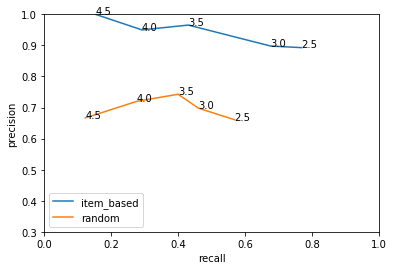

In [56]:
treshold_used = 3.75
treshold_recommended = [2.5,3.,3.5,4.,4.5]

recommended_item_based = [recommended(PR_test, thresh) for thresh in treshold_recommended]
hidden_item_based = [hidden(PR_test, thresh) for thresh in treshold_recommended]
used_item_based = used(PR_test, treshold_used)
unused_item_based = unused(PR_test, treshold_used)

recommended_random = [recommended(predicted_random, thresh) for thresh in treshold_recommended]
hidden_random = [hidden(predicted_random, thresh) for thresh in treshold_recommended]
used_random = used(predicted_random, treshold_used)
unused_random = unused(predicted_random, treshold_used)

confusion_item_based = [confusion(recommended_item_based[x],hidden_item_based[x],used_item_based,unused_item_based) for x in range(len(treshold_recommended))]
confusion_random = [confusion(recommended_random[x],hidden_random[x],used_random,unused_random) for x in range(len(treshold_recommended))]

precision_item_based = [precision(confusion_item_based[x]) for x in range(len(treshold_recommended))]
recall_item_based = [recall(confusion_item_based[x]) for x in range(len(treshold_recommended))]

precision_random = [precision(confusion_random[x]) for x in range(len(treshold_recommended))]
recall_random = [recall(confusion_random[x]) for x in range(len(treshold_recommended))]

plt.plot(recall_item_based, precision_item_based)
for r, p, t in zip(recall_item_based, precision_item_based, treshold_recommended):
    plt.text(r, p, t)

plt.plot(recall_random, precision_random)
for r, p, t in zip(recall_random, precision_random, treshold_recommended):
    plt.text(r, p, t)
    
plt.xlim(0.0, 1.0)
plt.ylim(0.3, 1.0)
plt.xlabel('recall')
plt.ylabel('precision')


plt.legend(['item_based','random'], loc = 'lower left')

### F1 Score

In [57]:
# F1 = 2 * (precision * recall) / (precision + recall)

F1_item = 2 * (precision_item_based[0] * recall_item_based[0]) / (precision_item_based[0] + recall_item_based[0])
F1_random = 2 * (precision_random[0] * recall_random[0]) / (precision_random[0] + recall_random[0])

display(F1_item)
display(F1_random)

0.8264462809917357

0.6115702479338843